# Simple regression model

In [1]:
from toolbox import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random

In [2]:
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFECV, SelectFromModel

from sklearn.model_selection import GridSearchCV

In [4]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

## Load data

In [5]:
ws = load_weather_station_data('./data/weather_station_list.csv')
w = load_weather_data('./data/weather_collections/weather_daily_region.csv')

gs = load_groundwater_station_data('./data/groundwater/bergstraße/gw_stations_bergstraße.csv')
g = load_groundwater_data('./data/groundwater/bergstraße/gw.csv')

gs_agg = calc_aggregate_station_data(gs, g)
# setting more years improves model predictions
gs_agg = calc_initial_station_data(gs_agg, g, initial_n_years=5) 


### Create regional clusters from gw stations

A good number of clusters is 10-12. Re-run if station data is changed.

In [6]:
#explore_clusters(gs_agg[['x', 'y']])

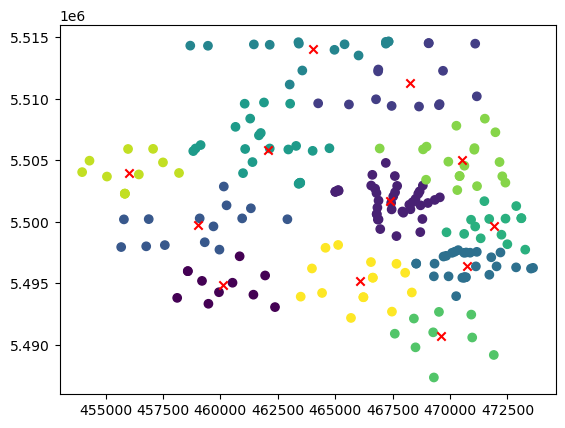

In [7]:
labels, centers = apply_clusters(gs_agg[['x', 'y']], 12, scale=False)

# Plot the points
plt.scatter(gs_agg['x'], gs_agg['y'], c=labels)#, cmap='viridis')

# Plot the cluster centers
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x')

# Show the plot
plt.show()

# Add clusters to stations
gs_agg['reg_clusters'] = labels
#gs_agg['reg_clusters'] = 0

### Merge data

In [8]:
g_merged = merge_groundwater_data(g, gs_agg)
g_merged.describe()

,station_id,date,water_dist,water_level,water_depth,water_temp,x,y,start_date,end_date,...,lifespan,water_level_mean,water_depth_mean,water_temp_mean,ini_years_water_depth_mean,ini_years_water_depth_std,ini_years_water_depth_min,ini_years_water_depth_max,reg_clusters,water_depth_anomaly
count,557260.000000,557260,554273.000000,554273.000000,554273.000000,66890.00000,557260.000000,5.572600e+05,557260,557260,...,557260,557247.000000,557247.000000,144944.000000,556928.000000,556928.000000,556928.000000,556928.000000,557260.000000,553988.000000
mean,13589.102144,1995-03-01 05:35:27.078921728,3.594004,89.469690,3.220631,12.27388,465759.276823,5.501905e+06,1966-12-22 22:03:30.291784800,2017-11-11 00:57:30.511431168,...,18586 days 02:54:00.219646208,89.466250,3.222664,12.190641,2.935128,0.382943,1.936159,3.645997,5.000355,0.286287
min,12890.000000,1912-10-15 00:00:00,0.000000,81.140000,-0.870000,2.02000,453983.000000,5.487354e+06,1912-01-01 00:00:00,1966-01-01 00:00:00,...,134 days 00:00:00,83.935770,0.968683,10.746667,0.464138,0.086603,-0.400000,1.010000,0.000000,-4.982107
25%,13157.000000,1980-08-25 00:00:00,2.500000,86.900000,2.100000,11.30000,461900.003000,5.497120e+06,1953-01-01 00:00:00,2024-03-01 00:00:00,...,15765 days 00:00:00,86.885700,2.210565,11.493786,1.906583,0.252264,0.680000,2.420000,2.000000,-0.323640
50%,13568.000000,1997-12-01 00:00:00,3.360000,89.240000,3.030000,12.00000,466857.965000,5.501588e+06,1973-01-01 00:00:00,2024-03-01 00:00:00,...,18322 days 00:00:00,89.014528,3.028495,11.959470,2.638494,0.329315,1.640000,3.410000,5.000000,0.192644
75%,13774.000000,2013-08-22 00:00:00,4.400000,92.090000,4.040000,12.90000,469927.000000,5.505957e+06,1978-01-01 00:00:00,2024-03-01 00:00:00,...,23801 days 00:00:00,91.933931,4.000772,12.636749,3.708372,0.498628,2.630000,4.630000,7.000000,0.792597
max,17794.000000,2024-03-20 00:00:00,11.160000,96.270000,10.790000,21.30000,473615.000000,5.514651e+06,2013-01-01 00:00:00,2024-03-01 00:00:00,...,40968 days 00:00:00,94.533442,8.493808,14.117103,9.237011,1.161315,7.580000,10.790000,11.000000,5.809157
std,609.112889,NaN,1.527469,3.005891,1.476485,1.55057,4829.443303,6.203696e+03,NaN,NaN,...,6842 days 14:06:22.419255168,2.932930,1.320438,0.818067,1.541130,0.175666,1.604714,1.599203,3.253354,1.075466


In [9]:
g_merged.head()

,station_id,date,water_dist,water_level,water_depth,water_temp,x,y,start_date,end_date,...,geometry,water_level_mean,water_depth_mean,water_temp_mean,ini_years_water_depth_mean,ini_years_water_depth_std,ini_years_water_depth_min,ini_years_water_depth_max,reg_clusters,water_depth_anomaly
date,,,,,,,,,,,,,,,,,,,,,
1979-01-01,13595,1979-01-01,9.48,89.76,8.45,NaN,468527.0,5496600.0,1978-01-01,2024-03-01,...,POINT (8.56426 49.62114),90.031838,8.178162,NaN,8.522269,0.768206,7.05,9.65,4,-0.072269
1979-01-08,13595,1979-01-08,9.49,89.75,8.46,NaN,468527.0,5496600.0,1978-01-01,2024-03-01,...,POINT (8.56426 49.62114),90.031838,8.178162,NaN,8.522269,0.768206,7.05,9.65,4,-0.062269
1979-01-15,13595,1979-01-15,9.89,89.35,8.86,NaN,468527.0,5496600.0,1978-01-01,2024-03-01,...,POINT (8.56426 49.62114),90.031838,8.178162,NaN,8.522269,0.768206,7.05,9.65,4,0.337731
1979-01-29,13595,1979-01-29,9.98,89.26,8.95,NaN,468527.0,5496600.0,1978-01-01,2024-03-01,...,POINT (8.56426 49.62114),90.031838,8.178162,NaN,8.522269,0.768206,7.05,9.65,4,0.427731
1979-02-05,13595,1979-02-05,10.00,89.24,8.97,NaN,468527.0,5496600.0,1978-01-01,2024-03-01,...,POINT (8.56426 49.62114),90.031838,8.178162,NaN,8.522269,0.768206,7.05,9.65,4,0.447731


In [10]:
m = pd.merge(g_merged, w,
             how='left', left_index=True, right_index=True)

# restrict data to the post-war period
m = m.loc[m.date > pd.to_datetime('1950-01-01')]

# drop all rows with a date after the weather data cutoff date
m = m.loc[m.date <= pd.to_datetime('2022-12-31')]

m = m.dropna(subset=['station_id_count'])

m['week_of_year'] = m['date'].dt.isocalendar().week

In [11]:
#m.info()

In [12]:
m.describe()

,station_id,date,water_dist,water_level,water_depth,water_temp,x,y,start_date,end_date,...,precip_mean_prev_90d_sum,precip_mean_prev_1y_sum,precip_mean_prev_3y_sum,tmean_mean_prev_2d_mean,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean,tmean_mean_prev_1y_mean,tmean_mean_prev_3y_mean,week_of_year
count,535080.000000,535080,532286.000000,532286.000000,532286.000000,58281.000000,535080.000000,5.350800e+05,535080,535080,...,535080.000000,535080.000000,535080.000000,535080.000000,535080.000000,535080.000000,535080.000000,535080.000000,535080.000000,535080.0
mean,13584.383032,1995-01-26 12:10:28.768782208,3.605169,89.464313,3.229522,12.234722,465762.831671,5.501887e+06,1967-01-27 18:55:06.768333728,2017-11-06 20:27:37.017267712,...,168.136895,681.624260,2045.571185,10.468712,10.443488,10.444661,10.441032,10.405230,10.381969,26.661774
min,12890.000000,1950-01-02 00:00:00,0.000000,81.140000,-0.870000,2.020000,453983.000000,5.487354e+06,1912-01-01 00:00:00,1966-01-01 00:00:00,...,41.320000,422.628571,1484.700000,-13.658333,-11.031746,-8.513333,-4.064444,7.622348,8.908018,1.0
25%,13159.000000,1980-11-03 00:00:00,2.500000,86.900000,2.110000,11.300000,461900.003000,5.497120e+06,1953-01-01 00:00:00,2024-03-01 00:00:00,...,127.200000,596.247024,1919.041667,4.833333,4.785714,4.592000,4.935926,9.895108,9.926751,14.0
50%,13564.000000,1997-05-26 00:00:00,3.370000,89.240000,3.040000,12.000000,466857.965000,5.501538e+06,1973-01-01 00:00:00,2024-03-01 00:00:00,...,163.850000,679.457143,2027.116667,10.546875,10.403571,10.344762,10.422540,10.424680,10.359142,27.0
75%,13773.000000,2012-11-19 00:00:00,4.410000,92.100000,4.070000,12.800000,469937.000000,5.505957e+06,1978-01-01 00:00:00,2024-03-01 00:00:00,...,204.142857,762.800000,2155.457143,16.375000,16.451020,16.551667,16.147460,10.970466,10.872871,40.0
max,17794.000000,2022-12-31 00:00:00,11.160000,96.270000,10.790000,21.300000,473615.000000,5.514651e+06,2013-01-01 00:00:00,2024-03-01 00:00:00,...,384.700000,1032.071429,2712.657143,29.850000,28.671429,24.437778,22.301852,12.782055,11.862146,53.0
std,599.613919,NaN,1.521245,2.998210,1.477947,1.549757,4850.075874,6.171791e+03,NaN,NaN,...,54.912199,111.445324,204.146600,7.384290,7.094874,6.682626,5.995027,0.837589,0.659717,15.052767


## Create intuitive dummy model

As baseline, we can assume that water_depth is proportional to temp.

In [13]:
def dummy_model(t):
    return 0.05 * t + 2

dummy_model(10)

2.5

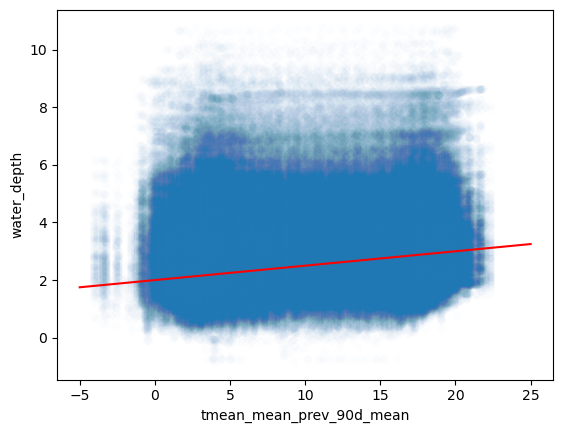

In [14]:
m_plot = m[['tmean_mean_prev_90d_mean', 'water_depth']].reset_index()
m_plot

sns.scatterplot(data=m_plot, 
            x='tmean_mean_prev_90d_mean', y='water_depth',
            alpha=0.01)
            
# works but is very slow (takes 10 minutes)
#sns.kdeplot(data=m_plot, 
#            x='tmean_mean_prev_30d_mean', y='water_depth',
               #alpha=0.01
#           )

x1, x2 = -5, 25
plt.plot([x1, x2],[dummy_model(x1), dummy_model(x2)], 'r');
            

## Train-test split

In [15]:
m.columns.unique()

Index(['station_id', 'date', 'water_dist', 'water_level', 'water_depth',
       'water_temp', 'x', 'y', 'start_date', 'end_date', 'ground_elev',
       'measure_elev', 'lifespan', 'geometry', 'water_level_mean',
       'water_depth_mean', 'water_temp_mean', 'ini_years_water_depth_mean',
       'ini_years_water_depth_std', 'ini_years_water_depth_min',
       'ini_years_water_depth_max', 'reg_clusters', 'water_depth_anomaly',
       'station_id_count', 'precip_mean', 'precip_min', 'precip_max',
       'precip_std', 'tmean_mean', 'tmean_min', 'tmean_max', 'tmean_std',
       'tmax_mean', 'tmax_min', 'tmax_max', 'tmax_std', 'tmin_mean',
       'tmin_min', 'tmin_max', 'tmin_std', 'moisture_mean', 'moisture_min',
       'moisture_max', 'moisture_std', 'precip_mean_prev_2d_sum',
       'precip_mean_prev_7d_sum', 'precip_mean_prev_30d_sum',
       'precip_mean_prev_90d_sum', 'precip_mean_prev_1y_sum',
       'precip_mean_prev_3y_sum', 'tmean_mean_prev_2d_mean',
       'tmean_mean_prev_7d_mean'

In [16]:
# restrict data to these columns
df = m[['station_id',
        'date',
        'water_depth',
        'ground_elev',
        'x', 'y',
        'reg_clusters',
        'ini_years_water_depth_mean',
        'ini_years_water_depth_std',
        'ini_years_water_depth_min',
        'ini_years_water_depth_max',
        'precip_mean',
        'tmean_mean',
        'moisture_mean',
        'precip_mean_prev_2d_sum',
        'precip_mean_prev_7d_sum',
        'precip_mean_prev_30d_sum',
        'precip_mean_prev_90d_sum',
        'precip_mean_prev_1y_sum',
        'precip_mean_prev_3y_sum',
        'tmean_mean_prev_2d_mean',
        'tmean_mean_prev_7d_mean',
        'tmean_mean_prev_30d_mean',
        'tmean_mean_prev_90d_mean',
        'tmean_mean_prev_1y_mean',
        'tmean_mean_prev_3y_mean'
       ]]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 535080 entries, 1950-01-02 to 2022-12-31
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   station_id                  535080 non-null  int64         
 1   date                        535080 non-null  datetime64[ns]
 2   water_depth                 532286 non-null  float64       
 3   ground_elev                 535080 non-null  float64       
 4   x                           535080 non-null  float64       
 5   y                           535080 non-null  float64       
 6   reg_clusters                535080 non-null  int32         
 7   ini_years_water_depth_mean  534748 non-null  float64       
 8   ini_years_water_depth_std   534748 non-null  float64       
 9   ini_years_water_depth_min   534748 non-null  float64       
 10  ini_years_water_depth_max   534748 non-null  float64       
 11  precip_mean            

In [17]:
df[df.isna().any(axis=1)]

,station_id,date,water_depth,ground_elev,x,y,reg_clusters,ini_years_water_depth_mean,ini_years_water_depth_std,ini_years_water_depth_min,...,precip_mean_prev_30d_sum,precip_mean_prev_90d_sum,precip_mean_prev_1y_sum,precip_mean_prev_3y_sum,tmean_mean_prev_2d_mean,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean,tmean_mean_prev_1y_mean,tmean_mean_prev_3y_mean
date,,,,,,,,,,,,,,,,,,,,,
1950-08-15,12926,1950-08-15,NaN,89.20,463419.000,5514473.000,5,2.641859,0.443678,1.69,...,100.250000,261.150000,693.075000,1913.266786,18.975000,19.533929,19.599167,19.460139,11.301884,10.891500
1951-07-16,13490,1951-07-16,NaN,90.13,459101.000,5500279.000,3,2.373881,0.165081,1.87,...,81.166667,210.955556,859.973611,1997.573611,16.233333,19.669841,18.000370,15.442469,10.000708,10.469049
1951-07-16,12895,1951-07-16,NaN,87.21,458921.000,5505957.000,6,0.961513,0.397709,0.12,...,81.166667,210.955556,859.973611,1997.573611,16.233333,19.669841,18.000370,15.442469,10.000708,10.469049
1951-07-16,13726,1951-07-16,NaN,93.50,466857.965,5500178.987,1,1.906583,0.315678,1.22,...,81.166667,210.955556,859.973611,1997.573611,16.233333,19.669841,18.000370,15.442469,10.000708,10.469049
1951-07-16,13489,1951-07-16,NaN,88.23,455802.000,5500199.000,3,1.208079,0.379114,-0.13,...,81.166667,210.955556,859.973611,1997.573611,16.233333,19.669841,18.000370,15.442469,10.000708,10.469049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-12,12901,2022-12-12,NaN,90.56,461760.000,5507216.000,6,3.029500,0.186197,2.56,...,52.050000,223.150000,666.550000,1997.600000,-2.350000,0.439286,4.616667,9.841667,12.227945,11.484817
2022-12-19,13764,2022-12-19,NaN,96.13,472883.576,5501280.505,7,4.635420,0.930456,2.53,...,22.325000,190.075000,667.575000,1969.925000,-2.712500,-3.746429,1.835000,8.528333,12.062397,11.412237
2022-12-19,12901,2022-12-19,NaN,90.56,461760.000,5507216.000,6,3.029500,0.186197,2.56,...,22.325000,190.075000,667.575000,1969.925000,-2.712500,-3.746429,1.835000,8.528333,12.062397,11.412237


In [18]:
df = df.dropna()

In [19]:
ids = list(df.station_id.unique())

# Calculate 80% of the list's length
num_elements = round(len(ids) * 0.8)

# Randomly select 80% of the elements
train_ids = random.sample(ids, k=num_elements)

In [20]:
train = df.loc[df.station_id.isin(train_ids)]
test = df.loc[~df.station_id.isin(train_ids)]

In [21]:
train

,station_id,date,water_depth,ground_elev,x,y,reg_clusters,ini_years_water_depth_mean,ini_years_water_depth_std,ini_years_water_depth_min,...,precip_mean_prev_30d_sum,precip_mean_prev_90d_sum,precip_mean_prev_1y_sum,precip_mean_prev_3y_sum,tmean_mean_prev_2d_mean,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean,tmean_mean_prev_1y_mean,tmean_mean_prev_3y_mean
date,,,,,,,,,,,,,,,,,,,,,
1950-01-02,13491,1950-01-02,1.59,89.77,461330.000,5501099.000,3,1.375745,0.218806,0.85,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
1950-01-02,13492,1950-01-02,2.40,90.30,460271.000,5501339.000,3,2.165060,0.232807,1.65,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
1950-01-02,13518,1950-01-02,2.12,96.27,468337.000,5494261.000,11,1.996575,0.303054,1.15,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
1950-01-02,12896,1950-01-02,1.28,88.70,462150.000,5505957.000,6,1.037206,0.252420,0.68,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
1950-01-02,14082,1950-01-02,3.97,92.37,461440.000,5494081.000,0,3.634884,0.216650,3.09,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,13544,2022-12-31,1.61,95.89,470586.000,5495471.000,4,1.647645,0.344207,0.63,...,44.650,160.50,677.875,1995.800000,11.2000,8.939286,3.178333,8.268611,12.200137,11.475411
2022-12-31,13832,2022-12-31,2.00,93.71,470626.000,5504557.000,9,2.002682,0.277334,0.96,...,44.650,160.50,677.875,1995.800000,11.2000,8.939286,3.178333,8.268611,12.200137,11.475411
2022-12-31,13836,2022-12-31,8.54,99.92,472156.000,5504857.000,9,8.537297,0.555361,7.58,...,44.650,160.50,677.875,1995.800000,11.2000,8.939286,3.178333,8.268611,12.200137,11.475411


In [22]:
# define X and y
y_train = train.pop('water_depth')
y_test = test.pop('water_depth')

info_train = train[['station_id', 'date']].copy()
info_test = test[['station_id', 'date']].copy()

X_train = train.copy().drop(['station_id', 'date'], axis=1)
X_test = test.copy().drop(['station_id', 'date'], axis=1)

In [23]:
X_train

,ground_elev,x,y,reg_clusters,ini_years_water_depth_mean,ini_years_water_depth_std,ini_years_water_depth_min,ini_years_water_depth_max,precip_mean,tmean_mean,...,precip_mean_prev_30d_sum,precip_mean_prev_90d_sum,precip_mean_prev_1y_sum,precip_mean_prev_3y_sum,tmean_mean_prev_2d_mean,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean,tmean_mean_prev_1y_mean,tmean_mean_prev_3y_mean
date,,,,,,,,,,,,,,,,,,,,,
1950-01-02,89.77,461330.000,5501099.000,3,1.375745,0.218806,0.85,2.03,7.325,0.200,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
1950-01-02,90.30,460271.000,5501339.000,3,2.165060,0.232807,1.65,2.53,7.325,0.200,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
1950-01-02,96.27,468337.000,5494261.000,11,1.996575,0.303054,1.15,2.48,7.325,0.200,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
1950-01-02,88.70,462150.000,5505957.000,6,1.037206,0.252420,0.68,1.39,7.325,0.200,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
1950-01-02,92.37,461440.000,5494081.000,0,3.634884,0.216650,3.09,4.00,7.325,0.200,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,95.89,470586.000,5495471.000,4,1.647645,0.344207,0.63,2.26,0.000,15.075,...,44.650,160.50,677.875,1995.800000,11.2000,8.939286,3.178333,8.268611,12.200137,11.475411
2022-12-31,93.71,470626.000,5504557.000,9,2.002682,0.277334,0.96,2.56,0.000,15.075,...,44.650,160.50,677.875,1995.800000,11.2000,8.939286,3.178333,8.268611,12.200137,11.475411
2022-12-31,99.92,472156.000,5504857.000,9,8.537297,0.555361,7.58,9.40,0.000,15.075,...,44.650,160.50,677.875,1995.800000,11.2000,8.939286,3.178333,8.268611,12.200137,11.475411


In [24]:
#X_train.info()
#y_test.info()

In [25]:
# test dummy model
dummy_y_test_pred = dummy_model(X_test['tmean_mean_prev_90d_mean'])
dummy_y_test_pred

date
1950-01-02    2.326243
1950-01-02    2.326243
1950-01-04    2.314701
1950-01-09    2.288167
1950-01-09    2.288167
                ...   
2022-12-30    2.412028
2022-12-31    2.413431
2022-12-31    2.413431
2022-12-31    2.413431
2022-12-31    2.413431
Name: tmean_mean_prev_90d_mean, Length: 104075, dtype: float64

In [26]:
calc_metrics(y_test, dummy_y_test_pred)

MAE 1.197457839442625
RMSE 1.6784656519778676
MAPE 97259577444.32776
R2 -0.29425467901222757


{'MAE': 1.197457839442625,
 'RMSE': 1.6784656519778676,
 'MAPE': 97259577444.32776,
 'R2': -0.29425467901222757}

In [27]:
residuals = calc_residuals(y_test, dummy_y_test_pred)

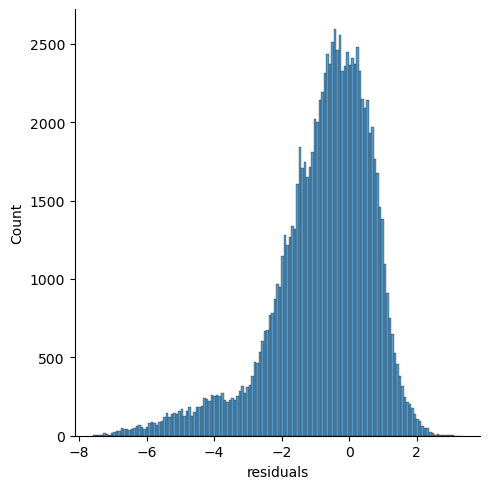

In [28]:
sns.displot(residuals['residuals'])

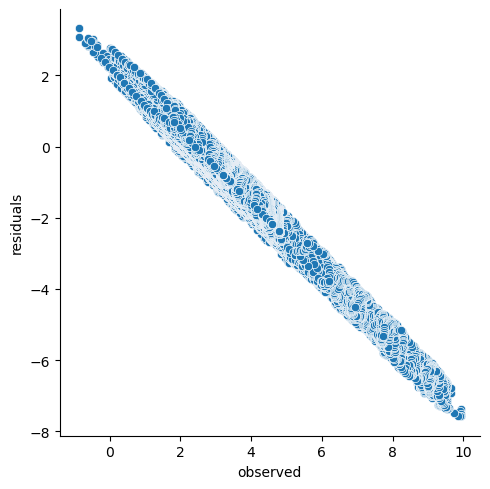

In [29]:
sns.relplot(data=residuals, x='observed', y='residuals')

## Exploratory PCA

In [30]:
pca, X_pca, pca_stats = perform_pca(X_train, 6)

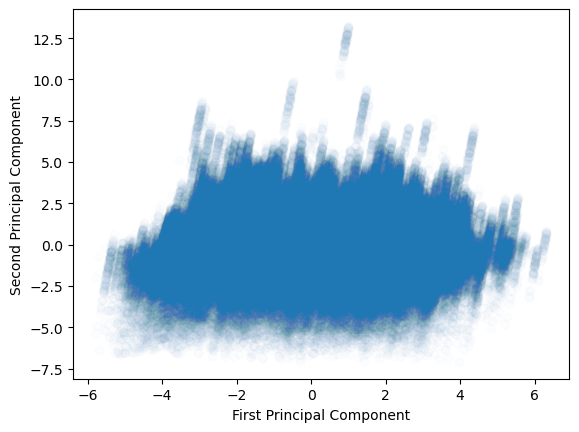

In [31]:
# Visualize the first two principal components
plt.scatter(X_pca['pca0'], X_pca['pca1'], alpha=0.01)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

In [32]:
pca_stats

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6
Explained Variance Ratio,0.201835,0.135608,0.128909,0.092904,0.088137,0.062094
ground_elev,-0.003294,-0.088803,0.152710,-0.536940,0.341200,-0.000280
x,0.001429,0.013964,0.006080,-0.464680,0.356191,-0.026844
y,0.000562,0.044245,-0.080008,0.330997,-0.217012,0.025820
reg_clusters,-0.006975,-0.091851,0.122813,-0.096933,0.032006,0.022486
ini_years_water_depth_mean,-0.028923,-0.342618,0.436610,0.021003,-0.143851,0.054472
ini_years_water_depth_std,-0.012018,-0.072245,0.070359,0.194973,-0.128853,-0.063544
ini_years_water_depth_min,-0.025761,-0.322760,0.417753,-0.064894,-0.082130,0.072925
ini_years_water_depth_max,-0.029274,-0.337671,0.427028,0.061742,-0.167376,0.042910
precip_mean,0.001893,0.270418,0.254540,0.184632,0.245260,0.299622


## Build initial pipelines

### Define preprocessing steps

In [33]:
#X_train.info()

In [34]:
# select categorical and numerical column names
#X_cat_columns = X_train.select_dtypes(exclude="number").columns
X_cat_columns = X_train.select_dtypes(include="int32").columns
X_num_columns = X_train.select_dtypes(include="float64").columns

# create numerical pipeline
num_pipe = Pipeline(
    steps=[('num_imputer', SimpleImputer(strategy='mean')), # probably not needed...
           #('num_scaler', MinMaxScaler())
           ('num_scaler', StandardScaler())
          ])

# create categorical pipeline, with the SimpleImputer(fill_value="N_A") and the OneHotEncoder
categoric_pipe = Pipeline(
    steps=[#('cat_imputer', SimpleImputer(strategy='constant', fill_value='na')), 
           ('cat_encoder', OneHotEncoder(drop='first', 
                                         sparse_output=False, 
                                         handle_unknown='ignore'))
           #('cat_encoder', OrdinalEncoder())
          ])

In [35]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, X_num_columns), 
        ('cat', categoric_pipe, X_cat_columns)
    ],
    #remainder='passthrough'
).set_output(transform='pandas')

In [36]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer()),
                                                 ('num_scaler',
                                                  StandardScaler())]),
                                 Index(['ground_elev', 'x', 'y', 'ini_years_water_depth_mean',
       'ini_years_water_depth_std', 'ini_years_water_depth_min',
       'ini_years_water_depth_max', 'precip_mean', 'tmean_mean',
       'moisture_mean', 'precip_mean_prev_2d_sum', 'precip_mean_prev_...
       'precip_mean_prev_1y_sum', 'precip_mean_prev_3y_sum',
       'tmean_mean_prev_2d_mean', 'tmean_mean_prev_7d_mean',
       'tmean_mean_prev_30d_mean', 'tmean_mean_prev_90d_mean',
       'tmean_mean_prev_1y_mean', 'tmean_mean_prev_3y_mean'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('cat_encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['reg_clusters'], dtype='object'))])

### Define regressors to test

In [37]:
regressors = [
    #('DecisionTree', DecisionTreeRegressor()), # not really good
    ('SGD', SGDRegressor()),
    ('LinReg', LinearRegression()),
    #('PLS', PLSRegression()),
    #('RandForest', RandomForestRegressor(n_estimators=30)), # best so far but costly (>10 min)
    ('HGBoost', HistGradientBoostingRegressor()), # excellent and very fast
    #('GBR', GradientBoostingRegressor()), # rel. slow and inferior to HGBR
    #('AdaBoost', AdaBoostRegressor()), # so far not good
    #('SVR' , SVR()), # extremely slow
    #('' ,()),
    #('' ,()),
    # try XGBoost
]

### Create a pipeline for each classifier

In [38]:
pipelines = {}
for name, reg in regressors:
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        #('selector', SelectKBest(score_func=f_regression)),
        #('selector', RFECV(estimator=DecisionTreeRegressor())),
        #('feature_selection', SelectFromModel(DecisionTreeRegressor())),
        ('regressor', reg)
     ]).set_output(transform="pandas")
    pipelines[name] = pipeline


In [39]:
pipelines['HGBoost']

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   StandardScaler())]),
                                                  Index(['ground_elev', 'x', 'y', 'ini_years_water_depth_mean',
       'ini_years_water_depth_std', 'ini_years_water_depth_min',
       'ini_years_water_depth_max', 'precip_mean', 'tmean_mean',
       'moisture_mean', 'precip_mean...
       'tmean_mean_prev_2d_mean', 'tmean_mean_prev_7d_mean',
       'tmean_mean_prev_30d_mean', 'tmean_mean_prev_90d_mean',
       'tmean_mean_prev_1y_mean', 'tmean_mean_prev_3y_mean'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['reg_clusters'], dtype='object'))])),
                ('regressor', HistGradientBoostingRegressor())])

## Inspect models

more or less stats from dummy model: 

MAE 1.180524150300254

RMSE 1.5993132760325228

MAPE 495545893932.64526

R2 -0.3085209566128313

In [40]:
predictions = {}
metrics = {}
residuals = {}

for name in pipelines:
    print(name)
    pipe = pipelines[name]

    #print('FITTING')
    pipe.fit(X_train, y_train)
    print('--- train data ---')
    calc_metrics(y_train, pipe.predict(X_train))

    #print('PREDICTING')
    y_pred = pipe.predict(X_test)

    # save
    print('--- test data ---')
    predictions[name] = y_pred
    metrics[name] = calc_metrics(y_test, y_pred)
    residuals[name] = calc_residuals(y_test, y_pred)

SGD
--- train data ---
MAE 0.5688827663773502
RMSE 0.7532376423585629
MAPE 72745950544.97473
R2 0.7394431407330884
--- test data ---
MAE 0.7166620449755895
RMSE 0.9668224136083492
MAPE 47170744794.785324
R2 0.5705740875504657
LinReg
--- train data ---
MAE 0.5627463606547364
RMSE 0.7504353619247088
MAPE 69264769263.77094
R2 0.7413782410195413
--- test data ---
MAE 0.7232695168599874
RMSE 0.9763473179015617
MAPE 46096998734.463425
R2 0.5620712049150621
HGBoost
--- train data ---
MAE 0.2850635871484382
RMSE 0.40448571038878955
MAPE 33422004377.666943
R2 0.9248645577575332
--- test data ---
MAE 0.5684155917286435
RMSE 0.805754532624527
MAPE 32922640484.75424
R2 0.701736340819195


In [41]:
#residuals['DecisionTree']

In [42]:
compare_models = pd.DataFrame(metrics)
compare_models

,SGD,LinReg,HGBoost
MAE,7.166620e-01,7.232695e-01,5.684156e-01
RMSE,9.668224e-01,9.763473e-01,8.057545e-01
MAPE,4.717074e+10,4.609700e+10,3.292264e+10
R2,5.705741e-01,5.620712e-01,7.017363e-01


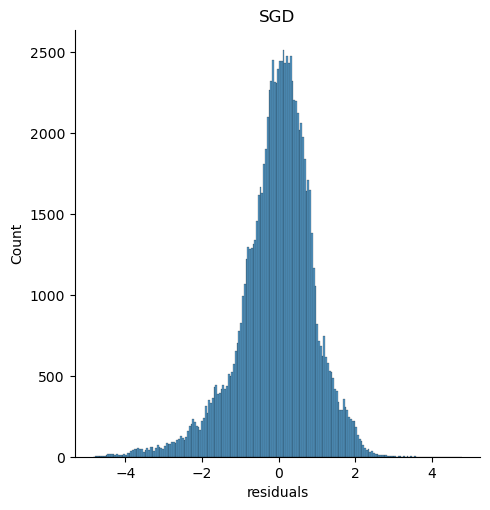

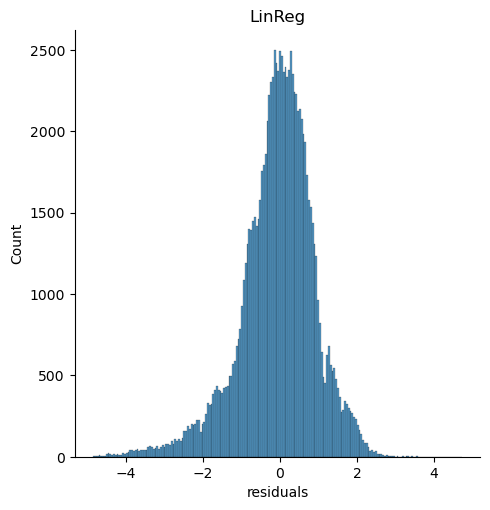

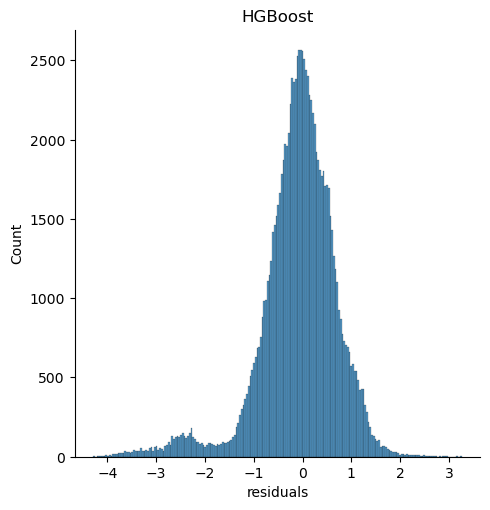

In [43]:
for name in residuals:
    #print(name)
    r = residuals[name]
    sns.displot(r['residuals']).set(title=name)

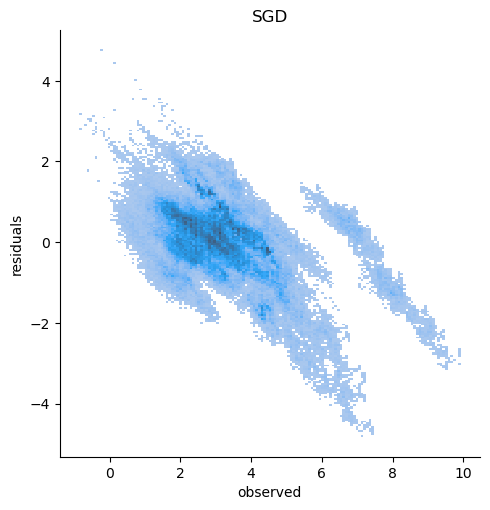

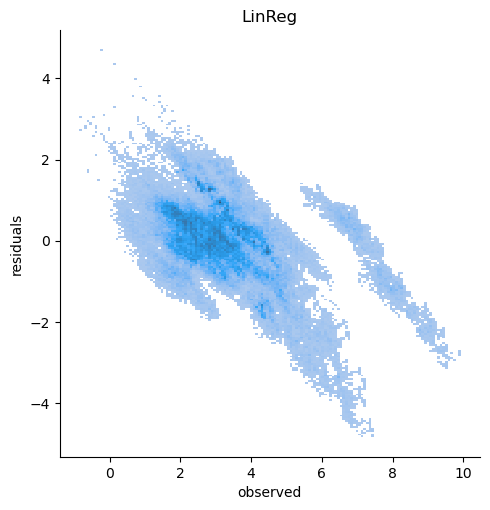

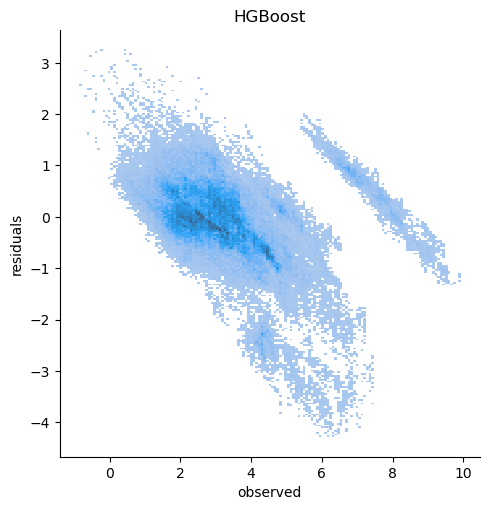

In [44]:
for name in residuals:
    r = residuals[name]
    #print(name, r.shape)
    sns.displot(data=r, x='observed', y='residuals').set(title=name)

In [45]:
#residuals['HGBoost']

In [46]:
model = 'HGBoost'
y_pred = predictions[model]
resid = residuals[model]

y_pred = pd.DataFrame(y_pred, columns=['pred_water_depth'])
y_pred.index = info_test.index
#y_pred

In [47]:
test = pd.concat([info_test, X_test, y_test, y_pred, resid['residuals']],
                 axis='columns')

In [48]:
#test.info()

In [49]:
#test.describe()

In [50]:
test.head()

,station_id,date,ground_elev,x,y,reg_clusters,ini_years_water_depth_mean,ini_years_water_depth_std,ini_years_water_depth_min,ini_years_water_depth_max,...,precip_mean_prev_3y_sum,tmean_mean_prev_2d_mean,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean,tmean_mean_prev_1y_mean,tmean_mean_prev_3y_mean,water_depth,pred_water_depth,residuals
date,,,,,,,,,,,,,,,,,,,,,
1950-01-02,12902,1950-01-02,87.63,460660.483,5507716.036,6,2.117403,0.498628,1.03,2.91,...,1746.344286,-0.9375,2.825000,4.0775,6.524861,11.005240,10.748059,3.03,2.581613,-0.448387
1950-01-02,12949,1950-01-02,91.26,464749.000,5505977.000,6,1.369872,0.388768,0.60,1.92,...,1746.344286,-0.9375,2.825000,4.0775,6.524861,11.005240,10.748059,2.43,2.228176,-0.201824
1950-01-04,13032,1950-01-04,90.92,464259.000,5509625.000,2,3.133808,0.341188,2.31,4.13,...,1752.794286,3.3125,1.503571,3.7950,6.294028,11.008493,10.768790,3.60,3.878035,0.278035
1950-01-09,12902,1950-01-09,87.63,460660.483,5507716.036,6,2.117403,0.498628,1.03,2.91,...,1749.206786,0.9750,3.633929,3.3100,5.763333,11.041781,10.809623,3.03,2.486293,-0.543707
1950-01-09,12949,1950-01-09,91.26,464749.000,5505977.000,6,1.369872,0.388768,0.60,1.92,...,1749.206786,0.9750,3.633929,3.3100,5.763333,11.041781,10.809623,2.41,2.102591,-0.307409


In [51]:
test.station_id.unique()[0]

12902

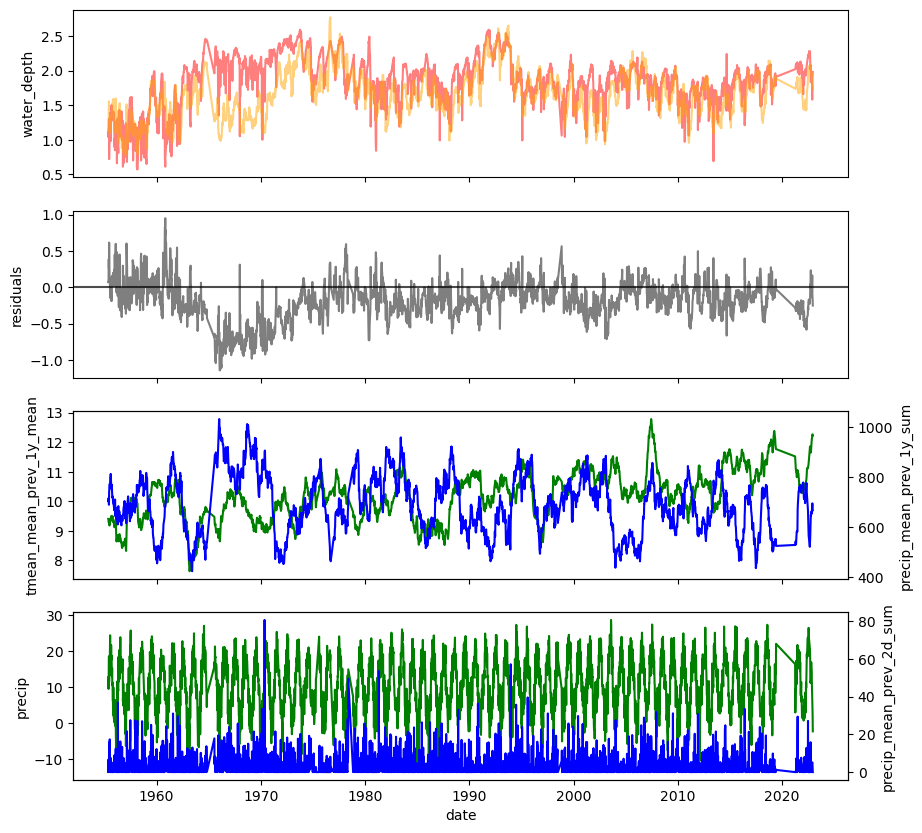

In [52]:
#data = test.loc[test.station_id == 13500]
data = test.loc[test.station_id == test.station_id.unique()[10]]

# Create a figure and an axis
fig, ax = plt.subplots(4,1, figsize=(10, 10), sharex=True)

# Plot the first DataFrame on the primary y-axis
sns.lineplot(x="date", y="water_depth",
             #hue="station_id", 
             #style="event",
             #palette='tab10',
             color='r', alpha=0.5,
             data=data,
             ax=ax[0])

# Plot the first DataFrame on the primary y-axis
sns.lineplot(x="date", y="pred_water_depth",
             #hue="station_id", 
             #style="event",
             #palette='tab10',
             color='orange', alpha=0.5,
             data=data,
             ax=ax[0])

# Plot the first DataFrame on the primary y-axis
sns.lineplot(x="date", y="residuals",
             #hue="station_id", 
             #style="event",
             #palette='tab10',
             color='k', alpha=0.5,
             data=data,
             ax=ax[1])

ax[1].axhline(y=0, color='k', alpha=0.7)
# Create a secondary y-axis
#ax[1] = ax[0].twinx()

# Plot the second DataFrame on the secondary y-axis
sns.lineplot(x="date", y="tmean_mean_prev_1y_mean", 
             data=data,#['1983-01':'1985-01'], # filter dates here
             ax=ax[2], 
             color='g'
            )

# Create a secondary y-axis
ax[2] = ax[2].twinx()

sns.lineplot(x="date", y="precip_mean_prev_1y_sum", 
             data=data,#['1983-01':'1985-01'], # filter dates here
             ax=ax[2], 
             color='b'
            )

# Optionally, set labels for the y-axes
ax[3].set_ylabel('precip')
#ax2.set_ylabel('Y2 Label')

# Plot the second DataFrame on the secondary y-axis
sns.lineplot(x="date", y="tmean_mean_prev_2d_mean", 
             data=data,#['1983-01':'1985-01'], # filter dates here
             ax=ax[3], 
             color='g'
            )

# Create a secondary y-axis
ax[3] = ax[3].twinx()

sns.lineplot(x="date", y="precip_mean_prev_2d_sum", 
             data=data,#['1983-01':'1985-01'], # filter dates here
             ax=ax[3], 
             color='b'
            )

# Optionally, set labels for the y-axes
#ax[3].set_ylabel('precip')
#ax2.set_ylabel('Y2 Label')

# Set the x-axis limits
start_date = pd.to_datetime('2000-01-01')
end_date = pd.to_datetime('2020-01-10')
#start_date = pd.to_datetime('1950-01-01')
#end_date = pd.to_datetime('1970-01-10')
#plt.xlim(start_date, end_date)

# Show the plot
plt.show()

## Hyperparameter search

### Define preprocessing steps

In [53]:
# select categorical and numerical column names
#X_cat_columns = X_train.select_dtypes(exclude="number").columns
X_cat_columns = X_train.select_dtypes(include="int32").columns
X_num_columns = X_train.select_dtypes(include="float64").columns

# create numerical pipeline
num_pipe = Pipeline(
    steps=[('num_imputer', SimpleImputer(strategy='mean')), # probably not needed...
           #('num_scaler', MinMaxScaler())
           ('num_scaler', StandardScaler())
          ])

# create categorical pipeline, with the SimpleImputer(fill_value="N_A") and the OneHotEncoder
categoric_pipe = Pipeline(
    steps=[#('cat_imputer', SimpleImputer(strategy='constant', fill_value='na')),
            #('cat_imputer', SimpleImputer(strategy='constant', fill_value=0)), 
           ('cat_encoder', OneHotEncoder(drop='first', 
                                         sparse_output=False, 
                                         handle_unknown='ignore'))
           #('cat_encoder', OrdinalEncoder())
          ])

In [54]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, X_num_columns), 
        ('cat', categoric_pipe, X_cat_columns)
    ],
    #remainder='passthrough'
).set_output(transform='pandas')

In [55]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer()),
                                                 ('num_scaler',
                                                  StandardScaler())]),
                                 Index(['ground_elev', 'x', 'y', 'ini_years_water_depth_mean',
       'ini_years_water_depth_std', 'ini_years_water_depth_min',
       'ini_years_water_depth_max', 'precip_mean', 'tmean_mean',
       'moisture_mean', 'precip_mean_prev_2d_sum', 'precip_mean_prev_...
       'precip_mean_prev_1y_sum', 'precip_mean_prev_3y_sum',
       'tmean_mean_prev_2d_mean', 'tmean_mean_prev_7d_mean',
       'tmean_mean_prev_30d_mean', 'tmean_mean_prev_90d_mean',
       'tmean_mean_prev_1y_mean', 'tmean_mean_prev_3y_mean'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('cat_encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['reg_clusters'], dtype='object'))])

### Define regressors to test

In [56]:
regressors = [
    #('SGD', SGDRegressor()),
    ('LinReg', LinearRegression()),
    ('HGBoost', HistGradientBoostingRegressor()), # excellent and very fast
]

### Create a pipeline for each regressor

In [57]:
pipelines = {}
for name, reg in regressors:
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        #('selector', SelectKBest(score_func=f_regression)),
        #('selector', RFECV(estimator=DecisionTreeRegressor())),
        #('feature_selection', SelectFromModel(DecisionTreeRegressor())),
        ('regressor', reg)
     ]).set_output(transform="pandas")
    pipelines[name] = pipeline


In [58]:
#pipelines['HGBoost']

### Define exploratory hyperparameters

In [59]:
param_grids_explore = {
    'SGD': {
        #'regressor__alpha': [0.00001, 0.001, 0.1], # d=0.0001
        'regressor__penalty': ['l1', 'l2', 'elasticnet'], # d='l2'
        #'regressor__learning_rate': ['optimal', 'invscaling' 'adaptive'], # d=invscaling
        #'regressor__max_iter': [100, 1000, 3000], # d=1000
        #'regressor__tol': [1e-3, 1e-4, 1e-5], # d=1e-3
        'regressor__loss': ['squared_epsilon_insensitive', 'epsilon_insensitive', 'squared_error'], # d=squared_error
        'regressor__early_stopping': [True, False], # d=False
        #'regressor__validation_fraction': [0.1, 0.2], # d=0.1
        'regressor__average': [True, False], # d=False
    },
    'LinReg': {
        # does not have tunable parameters
    },
    'HGBoost': {
        #'regressor__learning_rate': [0.01, 0.1, 0.2], # d=0.1
        'regressor__max_leaf_nodes': [5, 10, 30], # d=31
        'regressor__max_depth': [None, 5, 10], # d=None
        'regressor__min_samples_leaf': [5, 20, 50], # d=20
        'regressor__l2_regularization': [0, 0.1], # d=0
        #'regressor__max_bins': [255], # d=255
        #'regressor__categorical_features': list(str('cat__' + X_cat_columns.values))
        #TODO: try to get categorical_features running...
    }
}


### Fit and evaluate models

In [60]:
# Fit and evaluate each pipeline
scores_explore = {}
params_explore = {}
estimator_explore = {}
predictions = {}
metrics = {}
residuals = {}

fit_models = True # for turning off costly exploratory fitting

for name in pipelines:
    print(f"\nTraining and evaluating {name}...")
    pipe = pipelines[name]
    grid_search = GridSearchCV(pipe, 
                               param_grids_explore[name], 
                               cv=5, 
                               #scoring='neg_mean_absolute_error',
                               #scoring='neg_mean_squared_error',
                               #scoring='r2',
                               verbose=2, n_jobs=-1)
    
    if fit_models == True:
        grid_search.fit(X_train, y_train)
        
        # Evaluate on test set
        #y_pred = grid_search.predict(X_test)
        #accuracy = accuracy_score(y_test, y_pred)
        
        print("Best parameters found:")
        print(grid_search.best_params_)
        #print("Classification report:")
        #print(classification_report(y_test, y_pred))
        #print(f"Accuracy: {accuracy:.4f}")
        
        scores_explore[name] = grid_search.best_score_
        params_explore[name] = grid_search.best_params_
        estimator_explore[name] = grid_search

        print('--- predict test data ---')
        y_pred = grid_search.predict(X_test)
        predictions[name] = y_pred
        metrics[name] = calc_metrics(y_test, y_pred)
        residuals[name] = calc_residuals(y_test, y_pred)


Training and evaluating LinReg...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:
{}
--- predict test data ---
MAE 0.7232695168599874
RMSE 0.9763473179015617
MAPE 46096998734.463425
R2 0.5620712049150621

Training and evaluating HGBoost...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END .................................................... total time=   1.3s
[CV] END .................................................... total time=   0.7s
[CV] END regressor__l2_regularization=0, regressor__max_depth=None, regressor__max_leaf_nodes=5, regressor__min_samples_leaf=5; total time=   6.1s
[CV] END regressor__l2_regularization=0, regressor__max_depth=None, regressor__max_leaf_nodes=5, regressor__min_samples_leaf=20; total time=   5.7s
[CV] END regressor__l2_regularization=0, regressor__max_depth=None, regressor__max_leaf_nodes=5, regressor__min_samples_leaf=50; total time=   6.0s
[CV] END regressor__l2_regularization=0, regressor__max_de

In [61]:
scores_explore

{'LinReg': 0.6579469511353228, 'HGBoost': 0.6890819449548762}

In [62]:
pd.DataFrame(params_explore)

,LinReg,HGBoost
regressor__l2_regularization,NaN,0
regressor__max_depth,NaN,5
regressor__max_leaf_nodes,NaN,5
regressor__min_samples_leaf,NaN,5


In [63]:
estimator_explore['HGBoost']

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer()),
                                                                                         ('num_scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['ground_elev', 'x', 'y', 'ini_years_water_depth_mean',
       'ini_years_water_depth_std', 'ini_years_water_depth_min',
       'ini_years_water_depth_max', 'precip_mean', 'tmean_mean',...
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         Index(['reg_clusters'], dtype='object'))])),
                                       ('regressor',
                                        HistGradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__l2_regularization': [0, 0.1],
                         'regressor__max_depth': [None, 5, 10],
                         'regressor__max_leaf_nodes': [5, 10, 30],
                         'regressor__min_samples_leaf': [5, 20, 50]},
             verbose=2)

In [64]:
compare_models = pd.DataFrame(metrics)
compare_models

,LinReg,HGBoost
MAE,7.232695e-01,6.236232e-01
RMSE,9.763473e-01,8.515609e-01
MAPE,4.609700e+10,4.779335e+10
R2,5.620712e-01,6.668604e-01


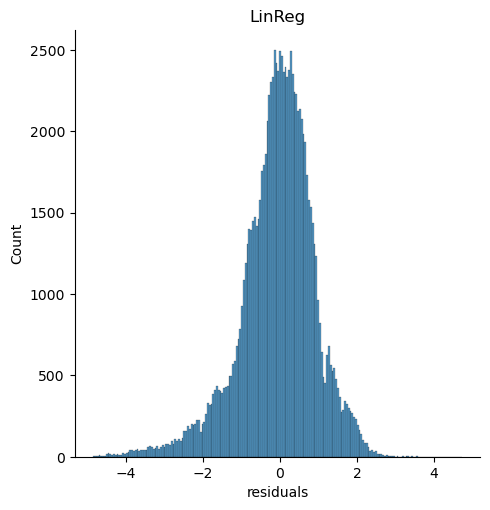

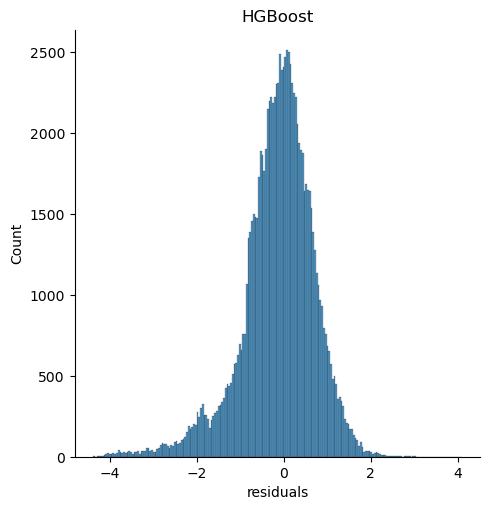

In [65]:
for name in residuals:
    #print(name)
    r = residuals[name]
    sns.displot(r['residuals']).set(title=name)

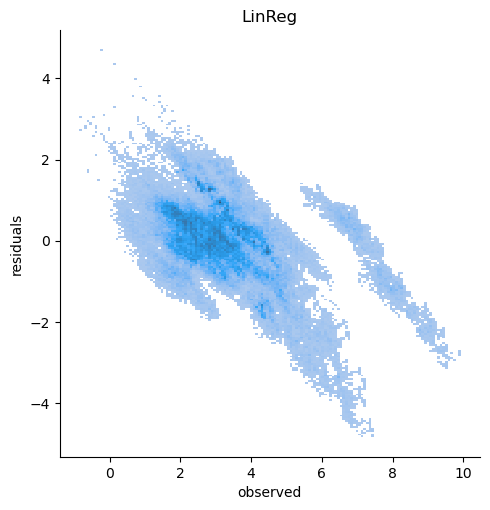

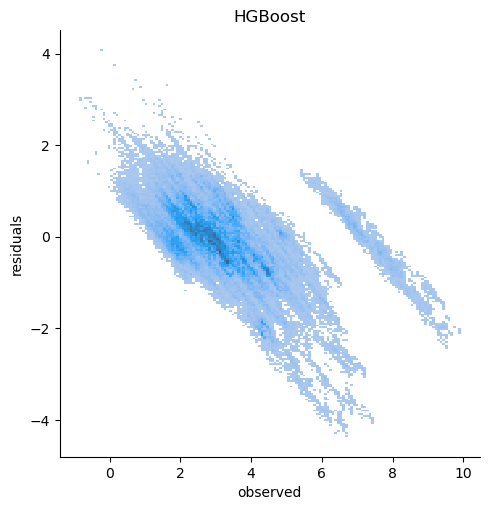

In [66]:
for name in residuals:
    r = residuals[name]
    #print(name, r.shape)
    sns.displot(data=r, x='observed', y='residuals').set(title=name)

### Analyse models

In [67]:
model = 'HGBoost'
y_pred = predictions[model]
resid = residuals[model]

y_pred = pd.DataFrame(y_pred, columns=['pred_water_depth'])
y_pred.index = info_test.index
#y_pred

In [68]:
test = pd.concat([info_test, X_test, y_test, y_pred, resid['residuals']],
                 axis='columns')

In [69]:
#test.info()

In [70]:
#test.describe()

In [71]:
test.head()

,station_id,date,ground_elev,x,y,reg_clusters,ini_years_water_depth_mean,ini_years_water_depth_std,ini_years_water_depth_min,ini_years_water_depth_max,...,precip_mean_prev_3y_sum,tmean_mean_prev_2d_mean,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean,tmean_mean_prev_1y_mean,tmean_mean_prev_3y_mean,water_depth,pred_water_depth,residuals
date,,,,,,,,,,,,,,,,,,,,,
1950-01-02,12902,1950-01-02,87.63,460660.483,5507716.036,6,2.117403,0.498628,1.03,2.91,...,1746.344286,-0.9375,2.825000,4.0775,6.524861,11.005240,10.748059,3.03,2.404176,-0.625824
1950-01-02,12949,1950-01-02,91.26,464749.000,5505977.000,6,1.369872,0.388768,0.60,1.92,...,1746.344286,-0.9375,2.825000,4.0775,6.524861,11.005240,10.748059,2.43,2.495075,0.065075
1950-01-04,13032,1950-01-04,90.92,464259.000,5509625.000,2,3.133808,0.341188,2.31,4.13,...,1752.794286,3.3125,1.503571,3.7950,6.294028,11.008493,10.768790,3.60,4.060919,0.460919
1950-01-09,12902,1950-01-09,87.63,460660.483,5507716.036,6,2.117403,0.498628,1.03,2.91,...,1749.206786,0.9750,3.633929,3.3100,5.763333,11.041781,10.809623,3.03,2.367899,-0.662101
1950-01-09,12949,1950-01-09,91.26,464749.000,5505977.000,6,1.369872,0.388768,0.60,1.92,...,1749.206786,0.9750,3.633929,3.3100,5.763333,11.041781,10.809623,2.41,2.458798,0.048798


In [72]:
test.station_id.unique()[0]

12902

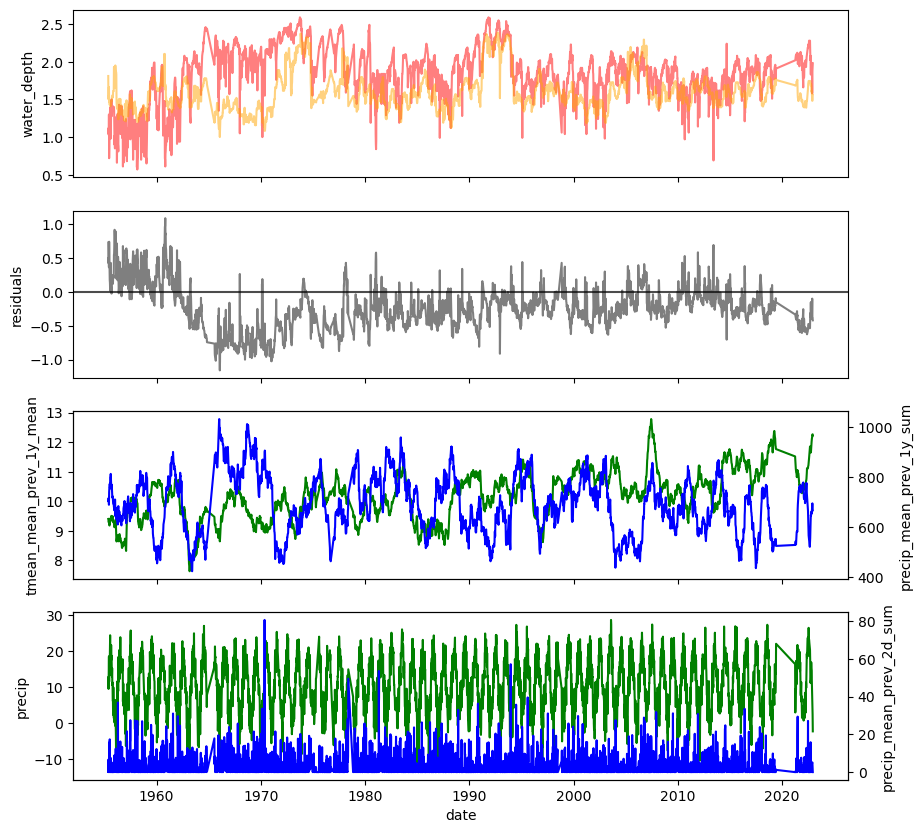

In [75]:
#data = test.loc[test.station_id == 13500]
data = test.loc[test.station_id == test.station_id.unique()[10]]

# Create a figure and an axis
fig, ax = plt.subplots(4,1, figsize=(10, 10), sharex=True)

# Plot the first DataFrame on the primary y-axis
sns.lineplot(x="date", y="water_depth",
             #hue="station_id", 
             #style="event",
             #palette='tab10',
             color='r', alpha=0.5,
             data=data,
             ax=ax[0])

# Plot the first DataFrame on the primary y-axis
sns.lineplot(x="date", y="pred_water_depth",
             #hue="station_id", 
             #style="event",
             #palette='tab10',
             color='orange', alpha=0.5,
             data=data,
             ax=ax[0])

# Plot the first DataFrame on the primary y-axis
sns.lineplot(x="date", y="residuals",
             #hue="station_id", 
             #style="event",
             #palette='tab10',
             color='k', alpha=0.5,
             data=data,
             ax=ax[1])

ax[1].axhline(y=0, color='k', alpha=0.7)
# Create a secondary y-axis
#ax[1] = ax[0].twinx()

# Plot the second DataFrame on the secondary y-axis
sns.lineplot(x="date", y="tmean_mean_prev_1y_mean", 
             data=data,#['1983-01':'1985-01'], # filter dates here
             ax=ax[2], 
             color='g'
            )

# Create a secondary y-axis
ax[2] = ax[2].twinx()

sns.lineplot(x="date", y="precip_mean_prev_1y_sum", 
             data=data,#['1983-01':'1985-01'], # filter dates here
             ax=ax[2], 
             color='b'
            )

# Optionally, set labels for the y-axes
ax[3].set_ylabel('precip')
#ax2.set_ylabel('Y2 Label')

# Plot the second DataFrame on the secondary y-axis
sns.lineplot(x="date", y="tmean_mean_prev_2d_mean", 
             data=data,#['1983-01':'1985-01'], # filter dates here
             ax=ax[3], 
             color='g'
            )

# Create a secondary y-axis
ax[3] = ax[3].twinx()

sns.lineplot(x="date", y="precip_mean_prev_2d_sum", 
             data=data,#['1983-01':'1985-01'], # filter dates here
             ax=ax[3], 
             color='b'
            )

# Optionally, set labels for the y-axes
#ax[3].set_ylabel('precip')
#ax2.set_ylabel('Y2 Label')

# Set the x-axis limits
start_date = pd.to_datetime('2000-01-01')
end_date = pd.to_datetime('2020-01-10')
#start_date = pd.to_datetime('1950-01-01')
#end_date = pd.to_datetime('1970-01-10')
#plt.xlim(start_date, end_date)

# Show the plot
plt.show()

## TODO

- implement location encoding by
    - discretizing x and y (pd.cut) and bucketing --> x-y grid
    - DONE performing clustering on the points with dbscan, kmean, knn, ...
- try to predict water_depth_anomaly?
- try with lag-shifted data...
- hyperparameter search
- examine model accuracy (min/max/std of resids, ...) of each station